Our goal is to understand whether our data has changed changed over time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

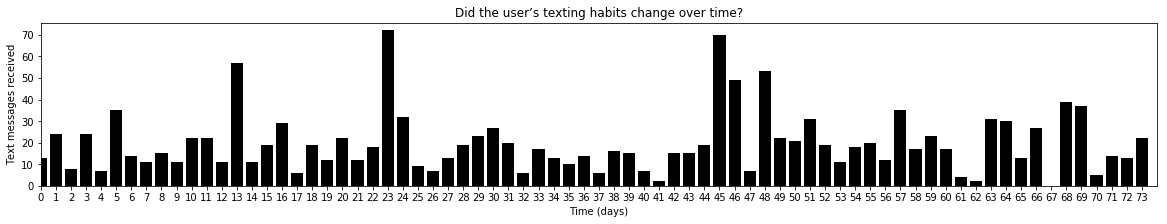

In [2]:
count_data = np.loadtxt("Data/txtdata.csv")
n_count_data = len(count_data)
f, ax = plt.subplots(figsize=(20, 3))
sns.barplot(np.arange(n_count_data), count_data, color = 'black');
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Did the user’s texting habits change over time?")
plt.xlim(0, n_count_data);

How can we model this data? Well one of the choices we have is the use of using a Poisson model. Why? Becuase this type of model works well with count data. 

$$C_i \text{~} Poi(\lambda)$$

For representation of our model lets assume that $\lambda$ will change after a point of time(t) in our data set $\tau$.

$$
\lambda = 
\begin{cases} 
      \lambda_1 & t < \tau \\
      \lambda_2 & t\geq \tau 
   \end{cases}
$$

The next puzzle to be solved is how do we estimate $\lambda$? The model assumptions state that $\lambda$ can take the form of any positive number. An exponential distribution provides a continuous density function, but the exponential distribution has its own parameters called $\alpha$. So....

$$
\lambda_i \text{~} Exp(\alpha)
$$


"When a random variable Z has an exponential distribution with parameter λ, we say Z is exponential and write Z ∼ Exp(λ) Given a specific λ, the expected value of an exponential random variable is equal to the
inverse of λ. That is,E[Z|λ] = $\frac{1}{λ}$" (Bayesian Methods for Hackers, Cameron Davidson)


Set $\alpha$ as the inverse of the average of the count data, based on the concept above.

$$\frac{1}{N}\sum_{\text{i=0}}^{N}C_i = E[\lambda|\alpha] = \frac{1}{\alpha}$$


Lastly $\tau$

$$\tau \text{~DiscrteUnif}(1,70)$$

For 70 days in the data set where $\tau$ is equally likely on each day.



In [3]:
import pymc as pm

#Alpha as described in above
alpha = 1.0/count_data.mean() 

# Exp distribution for lambda using alpha
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

#Uniform distribution for tau 
tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)


#Declare a deterministic result
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    
    #create a null vector of size == size(data)
    out = np.zeros(n_count_data)
    
    # t < tau will recieve lambda1
    out[:tau] = lambda_1
    
    #t > tau will recieve lambda2
    out[tau:] = lambda_2
    return out

#feeding custom function to observed poisson generator
observation = pm.Poisson("obs", lambda_, value=count_data,observed=True)

#declaring pymc model
model = pm.Model([observation, lambda_1, lambda_2, tau])

#blackbox MCMC model for sampling
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

#Drawing samples from mcmc model
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 4.7 sec

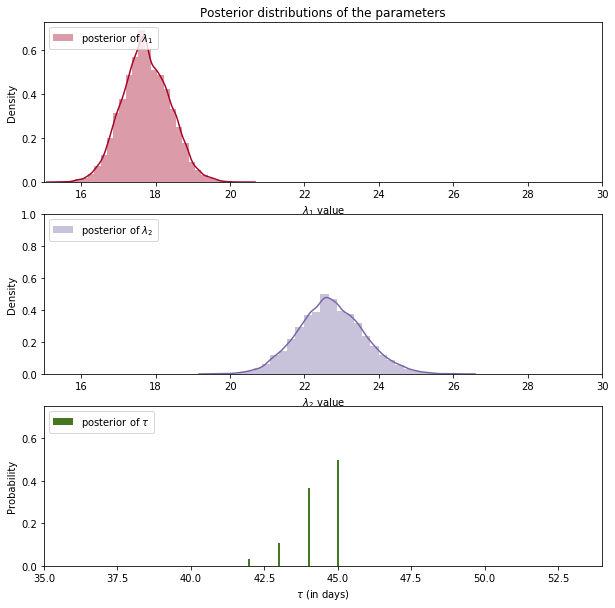

In [4]:
# histogram of the samples
f, ax = plt.subplots(figsize=(10, 10))


#plt sublot 1 declarartion (lambda 1)
ax = plt.subplot(311)
sns.distplot(lambda_1_samples, bins=30,label="posterior of $\lambda_1$", color="#A60628")
plt.legend(loc="upper left")

#declare main title
plt.title(r"""Posterior distributions of the parameters""")

plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")
#lambda1 plot ends


#plt sublot 2 declarartion (lambda 2) setting similar to plot 1
ax = plt.subplot(312)
ax.set_autoscaley_on(False)
sns.distplot(lambda_2_samples, bins=30,label="posterior of $\lambda_2$", color="#7A68A6")
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")



#plt sublot 2 declarartion (lambda 2)
plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$", color="#467821",
         weights=w, rwidth=2.)
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("Probability");



Analysis based on our run.<br />
<br />
1) $\lambda_1$,$\lambda_2$ can be expected to hold values of about 18 and 23 respectivley. <br />
2) Based on lambda distributions we can comment that there were differences in the two groups, recall that we assigned $\lambda_1$ to group t < $\tau$, and we changed $\lambda_2$ accordingly. Both groups were introduced to similar exponential distibution's and resulting posterior distribution's for each group were different from one another. <br />
2)  Posetrior distribution of $\tau$ is discrete. As based on our assumptions prior to output. <br />
3) Day 45 has a 50% chance og showing behavioral changes.


## Predicting $\lambda$ at time t

Some of the conditions to consider.<br />
<br />
Using the posterior distribution, given a day t.<br />
Average over all $\lambda$ <br />
Where <br />
&nbsp; $\lambda_i = \lambda_1$ for cases where $t < \tau_i$ <br />
Else <br />
&nbsp; $\lambda_i = \lambda_2$ <br />

In [16]:
n_count_data

74

In [26]:
# We give the variable N the value of shape size of tau samples which is 30,000. This corresponds to the sampling we
# did using MCMC methods
N = tau_samples.shape[0]

#We create an empty vector of size 74, the number of days that we are concerned about.
expected_texts_per_day = np.zeros(n_count_data)

# Create a loop from 0 to 73(Our index space)
for day in range(0, n_count_data):
    
    #tau samples is a 30,000 spaced vector which holds values for tau. Tau ranges between 41-46.
    # Due to this when we create the 30,000 space vector ix, it will conatined either True or false boolean 
    #values. So untill day is around 40-ish, you can expect ix to contain only True values.
    ix = day < tau_samples
    
    #Breaking this down now we assign each day in the expected_texts vector an averaged out value
    #Look at the example below to understand the multiplication process.
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()+ lambda_2_samples[~ix].sum()) / N

Lets break down the code above to a simple example: Assume we have 3 days, 5 sample values. <br />
<br />
N = length of Array $<a_1,a_2,a_3,a_4,a_5>$  = 5 <br />
<br />
Expected_texts_per_day = Array $<0,0,0>$<br />
<br />
Initiate variable day from 0 index to 2nd index:<br />
<br />
&nbsp; $\text{For iteration 1}$ <br />
<br />
&nbsp;ix = $<0,0,0,0,0>$ "<" $<2,1,2,2,2>$ = <True,True,True,True> = <1,1,1,1,1> <br />
<br />
&nbsp;Expected_texts_per_day indexed at day = 0 is currently 0, <br />
<br />
&nbsp;Assign the value <br />
&nbsp;$$ \sum_i (\lambda_1 \times ix) + \sum_i (\lambda_2 \times \text{inverse}(ix)) $$ <br />
&nbsp;$$= \sum_i (<12,13,12,12,13> \times <1,1,1,1,1>) + \sum_i (<14,15,14,14,15> \times <0,0,0,0,0>)$$ <br />
&nbsp;$$= \frac{62}{\text {Numer of days = 3}}  = \text{average amount per day}$$

<br />
<br />
&nbsp;$\text{For iteration 2}$ <br />
<br />
&nbsp;ix = $<1,1,1,1,1>$ "<" $<2,2,2,1,1>$ = <True,True,True,True> = <1,1,1,0,0> <br />
<br />
&nbsp;Expected_texts_per_day indexed at day = 1 is currently 0, <br />
<br />
Assign the value <br />
&nbsp;$$ \sum_i (\lambda_1 \times ix) + \sum_i (\lambda_2 \times \text{inverse}(ix)) $$ <br />
&nbsp;$$= \sum_i (<12,13,12,12,13> \times <1,1,1,0,0>) + \sum_i (<14,15,14,14,15> \times <0,0,0,1,1>)$$ <br />
&nbsp;$$= \frac{66}{\text {Numer of days = 3}}  = \text{average amount per day}$$

<br />
And so on...

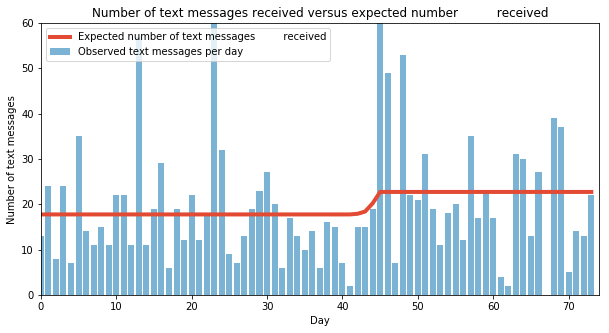

In [32]:
f, ax = plt.subplots(figsize=(10, 5))

plt.plot(range(n_count_data), expected_texts_per_day, lw=4,
         color="#E24A33", label="Expected number of text messages\
         received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Number of text messages")
plt.title("Number of text messages received versus expected number\
          received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD",
        alpha=0.65, label="Observed text messages per day")
plt.legend(loc="upper left") 

## Exercises

1. Using lambda 1 samples and lambda 2 samples, what is the mean of the posterior distributions of λ1 and λ2?<br /><br />
2. What is the expected percentage increase in text-message rates? Hint: Compute the mean of (lambda 2 samples-lambda 1 samples)<br />
lambda 1 samples. Note that this quantity is very different from
(lambda 2 samples.mean()-lambda 1 samples.mean())/ lambda 1 samples.mean().<br /><br />
3. What is the mean of λ1 given that we know τ is less than 45. That is, suppose we have been given new information that the change in behavior occurred prior to day 45. What is the expected value of λ1 now? (You do not need to redo the PyMC part. Just consider all instances where tau samples < 45.)

In [34]:
#Answer 1
mean_lambda_1 = np.mean(lambda_1_samples)
#Answer 2
mean_lambda_2 = np.mean(lambda_2_samples)

Mean Lambda1 = 17.742947542914454, Mean Lambda2 = 22.708088379218566


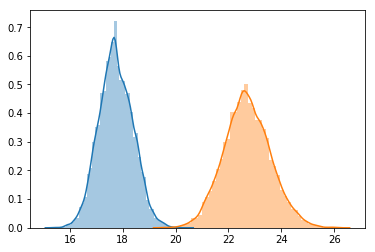

In [42]:
sns.distplot(lambda_1_samples)
sns.distplot(lambda_2_samples)
print ("Mean Lambda1 = {}, Mean Lambda2 = {}".format(mean_lambda_1,mean_lambda_2))

In [44]:
print ("Ans2:(Uncertain method) Expected increase in text rates = {} %".format(round((mean_lambda_2-mean_lambda_1)/mean_lambda_1*100)))

Ans2: Expected increase in text rates = 28.0 %


Ans2: Book method asnwer = 0.2815116411089795


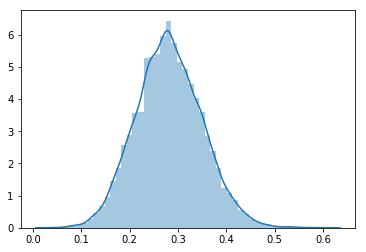

In [51]:
ans = (lambda_2_samples-lambda_1_samples)/lambda_1_samples
print ("Ans2: Book method asnwer = {}".format(np.mean(ans)))
sns.distplot(ans)

In [49]:
print ("Ans3: Mean lamda1 given new information = {}".format(
np.mean(lambda_1_samples[tau_samples< 45])))

Ans3: Mean lamda1 given new information = 17.74457347778962
